# Contents

### Tune ElasticNet model for all numerical and categorical Ames features 

[ElasticNet](#ElasticNet)

[Visualize train and test comparison](#Visualize-train-and-test-comparison)

[Model tuning](#Model-tuning)

[Summary](#Summary)


[Resources](#Resources)

[Extra](#Extra)
- [Visualize coefficients for varying alpha and rho](#Visualize-coefficients-for-varying-alpha-and-rho)

# Summary of previous data cleaning:

From **Ames_Data_Cleaning.ipynb**, the following modifications were made to the Ames dataset:

**Data Types**
- OverallQual and OverallCond reclassified as ordinal datatypes (per data dictionary)
- MSSubClass reclassified as categorical (nominal) datatype
- MoSold and YrSold redefined as categorical datatypes for modeling options
- Other date features remain numeric types, to prevent dimensionality problems when ordinal encoding
- GarageYrBlt changed from 'float' to 'int', after imputation of missing values, to match other date features.


**Missing Data and Imputation**
- Numerical Features:
    - After exploring relationship between GarageYrBlt and YearBuilt, imputed missing values with YearBuilt
    - After evaluating relationship between LotArea and LotFrontage, imputed LotFrontage with median
    - Imputed remaining numerical features with median values (meadian values are the same as the mode values for discrete features)
- Categorical Features:
    - Imputed missing Electrical value with mode value
    - After evaluating Garage features, imputed missing values with 'None'
    - Imputed remaining categorical features with 'None'

**ames_clean.pkl** include these changes.

In [3]:
# libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.feature_selection import SequentialFeatureSelector

from sklearn.linear_model import ElasticNet

ERROR! Session/line number was not unique in database. History logging moved to new session 3


In [4]:
# Import raw data, if needed for comparison
ames_raw = pd.read_csv('Ames_Housing_Price_Data.csv', index_col=0).reset_index()
ames_raw.drop(columns=['index'], inplace=True)
ames_raw.head(2)

,PID,GrLivArea,SalePrice,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,909176150,856,126000,30,RL,NaN,7890,Pave,NaN,Reg,...,166,0,NaN,NaN,NaN,0,3,2010,WD,Normal
1,905476230,1049,139500,120,RL,42.0,4235,Pave,NaN,Reg,...,0,0,NaN,NaN,NaN,0,2,2009,WD,Normal


In [5]:
# Import cleaned data: ames_clean.pkl
ames = pd.read_pickle('ames_clean.pkl')

## Define datatypes

### Numerical features

In [8]:
ames.select_dtypes(include=['float64', 'int64']).head(2)

,GrLivArea,SalePrice,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal
0,856,126000,68.0,7890,1939,1950,0.0,238.0,0.0,618.0,...,1939,2.0,399.0,0,0,0,0,166,0,0
1,1049,139500,42.0,4235,1984,1984,149.0,552.0,393.0,104.0,...,1984,1.0,266.0,0,105,0,0,0,0,0


In [9]:
ames.select_dtypes(include=['float64', 'int64']).columns

Index(['GrLivArea', 'SalePrice', 'LotFrontage', 'LotArea', 'YearBuilt',
       'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'BsmtFullBath',
       'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr',
       'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea',
       'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
       'ScreenPorch', 'PoolArea', 'MiscVal'],
      dtype='object')

**Note:** These are the correct, 32 numerical features

In [11]:
# Define numerical features without target SalePrice
numerical_features_list = ames.select_dtypes(include=['float64', 'int64']).columns.to_list()
numerical_features_list.remove('SalePrice')
print(f'number of numerical features (without target): {len(numerical_features_list)}')
numerical_features = ames[numerical_features_list]
numerical_features.head(2)

number of numerical features (without target): 31


,GrLivArea,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,...,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal
0,856,68.0,7890,1939,1950,0.0,238.0,0.0,618.0,856.0,...,1939,2.0,399.0,0,0,0,0,166,0,0
1,1049,42.0,4235,1984,1984,149.0,552.0,393.0,104.0,1049.0,...,1984,1.0,266.0,0,105,0,0,0,0,0


### Categorical features

In [13]:
print(f'number of categorical features: { len(ames.select_dtypes(include=["object"]).columns) }')

number of categorical features: 48


In [14]:
ames.select_dtypes(include=["object"]).columns

Index(['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour',
       'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1',
       'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu',
       'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive',
       'PoolQC', 'Fence', 'MiscFeature', 'MoSold', 'YrSold', 'SaleType',
       'SaleCondition'],
      dtype='object')

In [15]:
categorical_features = ames.select_dtypes(include=["object"])
categorical_features.head(2)

,MSSubClass,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,...,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,MoSold,YrSold,SaleType,SaleCondition
0,30,RL,Pave,None,Reg,Lvl,AllPub,Corner,Gtl,SWISU,...,TA,TA,Y,None,None,None,3,2010,WD,Normal
1,120,RL,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,Edwards,...,TA,TA,Y,None,None,None,2,2009,WD,Normal


In [16]:
categorical_features_list = categorical_features.columns.tolist()

In [17]:
# Define nominal features from Ames_Data_Cleaning.ipynb analysis
nominal_features_list = ['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LandContour',
                        'LotConfig', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 
                        'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 
                        'MasVnrType', 'Foundation', 'Heating', 'CentralAir', 'GarageType',
                        'MiscFeature', 'SaleType', 'SaleCondition']

print(f'number of nominal features: {len(nominal_features_list)}')
nominal_features = ames[nominal_features_list]
nominal_features.head(2)

number of nominal features: 23


,MSSubClass,MSZoning,Street,Alley,LandContour,LotConfig,Neighborhood,Condition1,Condition2,BldgType,...,Exterior1st,Exterior2nd,MasVnrType,Foundation,Heating,CentralAir,GarageType,MiscFeature,SaleType,SaleCondition
0,30,RL,Pave,None,Lvl,Corner,SWISU,Norm,Norm,1Fam,...,Wd Sdng,Wd Sdng,None,CBlock,GasA,Y,Detchd,None,WD,Normal
1,120,RL,Pave,None,Lvl,Inside,Edwards,Norm,Norm,TwnhsE,...,HdBoard,HdBoard,BrkFace,CBlock,GasA,Y,Attchd,None,WD,Normal


In [18]:
# Define ordinal features from Ames_Data_Cleaning.ipynb analysis
ordinal_features_list = ['Electrical', 'LotShape', 'Utilities', 'LandSlope', 'OverallQual', 'OverallCond',
                        'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
                        'BsmtFinType2', 'HeatingQC', 'KitchenQual', 'Functional',
                        'FireplaceQu', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive',
                        'PoolQC', 'Fence', 'MoSold', 'YrSold']
print(f'number of ordinal features: {len(ordinal_features_list)}')
ordinal_features = ames[ordinal_features_list]
ordinal_features.head(2)

number of ordinal features: 25


,Electrical,LotShape,Utilities,LandSlope,OverallQual,OverallCond,ExterQual,ExterCond,BsmtQual,BsmtCond,...,Functional,FireplaceQu,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MoSold,YrSold
0,SBrkr,Reg,AllPub,Gtl,6,6,TA,TA,TA,TA,...,Typ,Gd,Unf,TA,TA,Y,None,None,3,2010
1,SBrkr,Reg,AllPub,Gtl,5,5,Gd,TA,Gd,TA,...,Typ,None,Fin,TA,TA,Y,None,None,2,2009


In [19]:
# define features
X = ames[numerical_features_list].join(ames[categorical_features_list])
X.head(2)

,GrLivArea,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,...,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,MoSold,YrSold,SaleType,SaleCondition
0,856,68.0,7890,1939,1950,0.0,238.0,0.0,618.0,856.0,...,TA,TA,Y,None,None,None,3,2010,WD,Normal
1,1049,42.0,4235,1984,1984,149.0,552.0,393.0,104.0,1049.0,...,TA,TA,Y,None,None,None,2,2009,WD,Normal


In [20]:
# define target
y = ames['SalePrice']

# ElasticNet

[Contents](#Contents)

evaluate base model on full dataset and train-test split data to look for overfitting

In [22]:
# create storage for tuning results
tuning_results = {}

In [23]:
# numeric transformer for scaling
num_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# categorical transformer for encoding
cat_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(drop='first', sparse_output=True, handle_unknown='ignore')) 
])

# define the preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, numerical_features_list),
        ('cat', cat_transformer, categorical_features_list)
    ])

# define multiple model pipeline with preprocessor and regressor
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor), 
    ('regressor', ElasticNet(max_iter=20000))]
)

In [24]:
# fit model on all data for baseline
pipeline.fit(X, y)

# evaluate base model performance
scores = cross_val_score(pipeline, X, y)
mean_score_base_model = scores.mean()
print(f'cv scores:', scores)
print(f'mean-cv base model score:', round(mean_score_base_model, 4))

# refit pipeline on train-test data to look for overfitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 0)
pipeline.fit(X_train, y_train)
train_score = pipeline.score(X_train, y_train)
test_score = pipeline.score(X_test, y_test)
diff = train_score - test_score

print(f'base model train score:', round(train_score, 4))
print(f'base model test score:', round(test_score, 4))
print(f'base model train-test gap:', round(diff, 4))

tuning_results['Model _0'] = {
    'mean-cv on X and y': round(mean_score_base_model, 4),
    'train score': round(train_score, 4),
    'test score': round(test_score, 4),
    'train-test gap': round(diff, 4),
    'scenario': 'base model'
}

/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [18, 33, 34] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [17, 30, 43, 46] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [9, 17, 18, 19] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [11, 22] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


cv scores: [0.82339363 0.83151667 0.86787928 0.86045608 0.85699675]
mean-cv base model score: 0.848
base model train score: 0.8466
base model test score: 0.8572
base model train-test gap: -0.0106


/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 1, 6, 11, 18, 19, 29] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [11, 17, 18, 19, 46] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


# Visualize train and test comparison

[Contents](#Contents)

In [48]:
intercepts = []
coefs = []
scores = []
alphaRange = np.linspace(0.1,65000,20)

# fit preprocessor and transform data for ElasticNet visualization
preprocessor_fitted = pipeline.named_steps['preprocessor'].fit(X_train)
X_train_transformed = preprocessor_fitted.transform(X_train)

# for later
X_test_transformed = preprocessor_fitted.transform(X_test)

/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [11, 17, 18, 19, 46] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [50]:
X_train_transformed

<2064x304 sparse matrix of type '<class 'numpy.float64'>'
	with 149022 stored elements in Compressed Sparse Row format>

In [52]:
enet_train_R2 = []
enet_test_R2  = []
alphaRange= np.linspace(0.1,65000,20)
for alpha in alphaRange:
    enet = ElasticNet(alpha=alpha, max_iter=10000)
    enet.fit(X_train_transformed, y_train)   
    enet_train_R2.append(enet.score(X_train_transformed, y_train))
    enet_test_R2.append(enet.score(X_test_transformed, y_test))

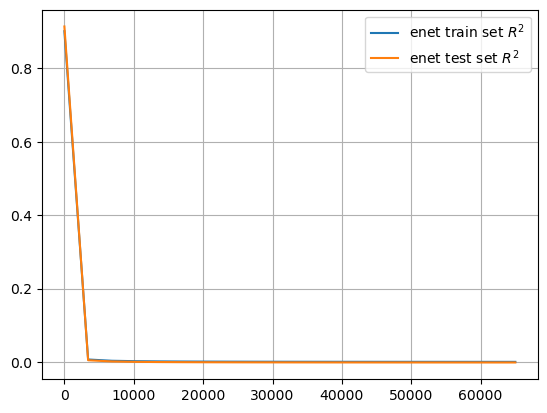

In [54]:
plt.plot(alphaRange, enet_train_R2, label=r'enet train set $R^2$')
plt.plot(alphaRange, enet_test_R2, label=r'enet test set $R^2$')
plt.legend(loc='upper right')
plt.grid()

# Model tuning

[Contents](#Contents)

In [58]:
# define range of alpha values for ElasticNet
alpha = list(range(1, 21, 1)) 
 
# define range of L1 ratio for ElasticNet
l1_ratio_1 = [0.05, 0.5, 0.95]


# initialize grid search for ElasticNet
enet_grid_1 = GridSearchCV(estimator=pipeline,
                         param_grid={'regressor__alpha': alpha, 
                                     'regressor__l1_ratio': l1_ratio_1},
                         verbose=1) 
 
enet_grid_1.fit(X, y)

# fit on all data for overall score
enet_grid_1.fit(X, y)
 
# Extract the best alpha and best score
enet_best_alpha_1 = enet_grid_1.best_params_['regressor__alpha']
enet_best_l1_ratio = enet_grid_1.best_params_['regressor__l1_ratio']
enet_best_score_1 = enet_grid_1.best_score_
print('MODEL _1:')
print('Evaluate model on full dataset:')
print(f'model parameters:', enet_best_alpha_1)
print(f'mean cv score on full dataset:', round(enet_best_score_1,4))
print('-----------')

# check for overfitting on train-test data
enet_grid_1.fit(X_train, y_train)
train_score = enet_grid_1.score(X_train, y_train)
test_score = enet_grid_1.score(X_test, y_test)
diff = train_score - test_score
print('Check for overfitting on train-test data:')
print(f'train score:', round(train_score,4))
print(f'test score:', round(test_score,4))
print(f'train-test gap:', round(diff,4))

tuning_results['Model _1'] = {
    'mean-cv on X and y': round(enet_best_score_1,4),
    'train score': round(train_score, 4),
    'test score': round(test_score, 4),
    'train-test gap': round(diff, 4) ,
    'scenario': f'alpha = {enet_best_alpha_1}, l1_ratio = {enet_best_alpha_1}'
}

Fitting 5 folds for each of 60 candidates, totalling 300 fits


/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [18, 33, 34] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [17, 30, 43, 46] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [9, 17, 18, 19] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [11, 22] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/prepr

Fitting 5 folds for each of 60 candidates, totalling 300 fits


/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [18, 33, 34] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [17, 30, 43, 46] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [9, 17, 18, 19] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [11, 22] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/prepr

MODEL _1:
Evaluate model on full dataset:
model parameters: 1
mean cv score on full dataset: 0.8957
-----------
Fitting 5 folds for each of 60 candidates, totalling 300 fits


/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [18, 29, 30] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [11, 17, 18, 41] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [0, 1, 18, 33, 34] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [9, 11, 24, 41] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/skl

Check for overfitting on train-test data:
train score: 0.9015
test score: 0.9143
train-test gap: -0.0128


/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [9, 11, 24, 41] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [9, 22, 29, 43] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [11, 17, 18, 19, 46] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [60]:
tuning_results

{'Model _0': {'mean-cv on X and y': 0.848,
  'train score': 0.8466,
  'test score': 0.8572,
  'train-test gap': -0.0106,
  'scenario': 'base model'},
 'Model _1': {'mean-cv on X and y': 0.8957,
  'train score': 0.9015,
  'test score': 0.9143,
  'train-test gap': -0.0128,
  'scenario': 'alpha = 1, l1_ratio = 1'},
 'Model _2': {'mean-cv on X and y': 0.9091,
  'train score': 0.9015,
  'test score': 0.9143,
  'train-test gap': -0.0128,
  'scenario': 'alpha = 0, l1_ratio = 0'}}

In [62]:
# adjust range of parameters
alpha = list(range(0, 20, 1)) 
l1_ratio_2 = [0.05, 0.5, 0.95]

# initialize grid search for ElasticNet
enet_grid_2 = GridSearchCV(estimator=pipeline,
                         param_grid={'regressor__alpha': alpha, 
                                     'regressor__l1_ratio': l1_ratio_2},
                         verbose=1) 
 
enet_grid_2.fit(X, y)

# fit on all data for overall score
enet_grid_2.fit(X, y)
 
# Extract the best alpha and best score
enet_best_alpha_2 = enet_grid_2.best_params_['regressor__alpha']
enet_best_l1_ratio = enet_grid_2.best_params_['regressor__l1_ratio']
enet_best_score_2 = enet_grid_2.best_score_
print('MODEL _2:')
print('Evaluate model on full dataset:')
print(f'model parameters:', enet_best_alpha_2)
print(f'mean cv score on full dataset:', round(enet_best_score_2,4))
print('-----------')

# check for overfitting on train-test data
enet_grid_2.fit(X_train, y_train)
train_score = enet_grid_2.score(X_train, y_train)
test_score = enet_grid_2.score(X_test, y_test)
diff = train_score - test_score
print('Check for overfitting on train-test data:')
print(f'train score:', round(train_score,4))
print(f'test score:', round(test_score,4))
print(f'train-test gap:', round(diff,4))

tuning_results['Model _2'] = {
    'mean-cv on X and y': round(enet_best_score_2,4),
    'train score': round(train_score, 4),
    'test score': round(test_score, 4),
    'train-test gap': round(diff, 4) ,
    'scenario': f'alpha = {enet_best_alpha_2}, l1_ratio = {enet_best_alpha_2}'
}

Fitting 5 folds for each of 60 candidates, totalling 300 fits


/opt/anaconda3/lib/python3.11/site-packages/sklearn/pipeline.py:405: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:592: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 254385594461.4352, tolerance: 1090499258.1211665
  model = cd_fast.sparse_enet_coordinate_descent(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [18, 33, 34] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/pipeline.py:405: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimato

Fitting 5 folds for each of 60 candidates, totalling 300 fits


/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:592: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 254385594461.4352, tolerance: 1090499258.1211665
  model = cd_fast.sparse_enet_coordinate_descent(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [18, 33, 34] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/pipeline.py:405: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:592: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3047

MODEL _2:
Evaluate model on full dataset:
model parameters: 0
mean cv score on full dataset: 0.9091
-----------
Fitting 5 folds for each of 60 candidates, totalling 300 fits


/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:592: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 208730633974.31274, tolerance: 954215036.228686
  model = cd_fast.sparse_enet_coordinate_descent(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [18, 29, 30] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/pipeline.py:405: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:592: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25506

Check for overfitting on train-test data:
train score: 0.9015
test score: 0.9143
train-test gap: -0.0128


/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [11, 17, 18, 19, 46] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


### Look at features selected by sfs

set alpha=0 and l1_ratio=.05

In [64]:
# numeric pipeline with sequential feature selection
num_transformer = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('sfs', SequentialFeatureSelector(
        estimator =  ElasticNet(max_iter=20000),
        n_features_to_select = 'auto',
        direction = 'forward',
        cv = 5,
        scoring = 'r2'
    ))
])

# categorical feature pipeline
cat_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'))
])

# combined preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, numerical_features_list),
        ('cat', cat_transformer, categorical_features_list)
    ])

# define pipeline with preprocessor and regressor
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor), ('regressor', ElasticNet(alpha=0, l1_ratio=0.05, max_iter=20000))]
)

In [66]:
# Time the procedure
import time

start_time = time.time()  # Record the start time

# adjust range of parameters
alpha = list(range(0, 20, 1)) 
l1_ratio_3 = [0.05, 0.5, 0.95]

# initialize grid search for ElasticNet
enet_grid_3 = GridSearchCV(estimator=pipeline,
                         param_grid={'regressor__alpha': alpha, 
                                     'regressor__l1_ratio': l1_ratio_3},
                         verbose=1) 
 
enet_grid_3.fit(X, y)

# fit on all data for overall score
enet_grid_3.fit(X, y)
 
# Extract the best alpha and best score
enet_best_alpha_3 = enet_grid_3.best_params_['regressor__alpha']
enet_best_l1_ratio = enet_grid_3.best_params_['regressor__l1_ratio']
enet_best_score_3 = enet_grid_3.best_score_
print('MODEL _3:')
print('Evaluate model on full dataset:')
print(f'model parameters:', enet_best_alpha_3)
print(f'mean cv score on full dataset:', round(enet_best_score_3,4))
print('-----------')

# check for overfitting on train-test data
enet_grid_3.fit(X_train, y_train)
train_score = enet_grid_3.score(X_train, y_train)
test_score = enet_grid_3.score(X_test, y_test)
diff = train_score - test_score
print('Check for overfitting on train-test data:')
print(f'train score:', round(train_score,4))
print(f'test score:', round(test_score,4))
print(f'train-test gap:', round(diff,4))

tuning_results['Model _3'] = {
    'mean-cv on X and y': round(enet_best_score_3,4),
    'train score': round(train_score, 4),
    'test score': round(test_score, 4),
    'train-test gap': round(diff, 4) ,
    'scenario': f'alpha = {enet_best_alpha_3}, l1_ratio = {enet_best_alpha_3}'
}

# Record the end time
end_time = time.time()  
            
# Calculate the execution time
execution_time = end_time - start_time  
print(f'Execution time: {execution_time} seconds')

Fitting 5 folds for each of 60 candidates, totalling 300 fits


/opt/anaconda3/lib/python3.11/site-packages/sklearn/pipeline.py:405: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.634e+11, tolerance: 1.090e+09 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fa

Fitting 5 folds for each of 60 candidates, totalling 300 fits


/opt/anaconda3/lib/python3.11/site-packages/sklearn/pipeline.py:405: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.634e+11, tolerance: 1.090e+09 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fa

MODEL _3:
Evaluate model on full dataset:
model parameters: 0
mean cv score on full dataset: 0.9095
-----------
Fitting 5 folds for each of 60 candidates, totalling 300 fits


/opt/anaconda3/lib/python3.11/site-packages/sklearn/pipeline.py:405: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.163e+11, tolerance: 9.542e+08 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fa

Check for overfitting on train-test data:
train score: 0.8991
test score: 0.9089
train-test gap: -0.0097
Execution time: 2852.1261990070343 seconds


/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:202: UserWarning: Found unknown categories in columns [11, 17, 18, 19, 46] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [67]:
tuning_results_df = pd.DataFrame(tuning_results).T
tuning_results_df.sort_values(by=['mean-cv on X and y'], ascending=False)

,mean-cv on X and y,train score,test score,train-test gap,scenario
Model _3,0.9095,0.8991,0.9089,-0.0097,"alpha = 0, l1_ratio = 0"
Model _2,0.9091,0.9015,0.9143,-0.0128,"alpha = 0, l1_ratio = 0"
Model _1,0.8957,0.9015,0.9143,-0.0128,"alpha = 1, l1_ratio = 1"
Model _0,0.848,0.8466,0.8572,-0.0106,base model


# Summary

[Contents](#Contents)

$$\alpha \cdot (1 - \rho) \cdot ||\vec{\beta}||_{L^2}^2 + \alpha \cdot \rho \cdot ||\vec{\beta}||_{L^1}$$

In [70]:
tuning_results_df

,mean-cv on X and y,train score,test score,train-test gap,scenario
Model _0,0.848,0.8466,0.8572,-0.0106,base model
Model _1,0.8957,0.9015,0.9143,-0.0128,"alpha = 1, l1_ratio = 1"
Model _2,0.9091,0.9015,0.9143,-0.0128,"alpha = 0, l1_ratio = 0"
Model _3,0.9095,0.8991,0.9089,-0.0097,"alpha = 0, l1_ratio = 0"


In [72]:
# save data for model comparisons
enet_models = tuning_results_df.copy()
enet_models['algorithm'] = 'ElasticNet'
enet_models

,mean-cv on X and y,train score,test score,train-test gap,scenario,algorithm
Model _0,0.848,0.8466,0.8572,-0.0106,base model,ElasticNet
Model _1,0.8957,0.9015,0.9143,-0.0128,"alpha = 1, l1_ratio = 1",ElasticNet
Model _2,0.9091,0.9015,0.9143,-0.0128,"alpha = 0, l1_ratio = 0",ElasticNet
Model _3,0.9095,0.8991,0.9089,-0.0097,"alpha = 0, l1_ratio = 0",ElasticNet


In [74]:
enet_models.index.name = 'model'
enet_models = enet_models.reset_index()
enet_models

,model,mean-cv on X and y,train score,test score,train-test gap,scenario,algorithm
0,Model _0,0.848,0.8466,0.8572,-0.0106,base model,ElasticNet
1,Model _1,0.8957,0.9015,0.9143,-0.0128,"alpha = 1, l1_ratio = 1",ElasticNet
2,Model _2,0.9091,0.9015,0.9143,-0.0128,"alpha = 0, l1_ratio = 0",ElasticNet
3,Model _3,0.9095,0.8991,0.9089,-0.0097,"alpha = 0, l1_ratio = 0",ElasticNet


In [76]:
enet_models.to_csv('elasticNet_models.csv')

# Resources
[Return To Top](#Contents)

**Dean De Cock paper and original data:**

- [Ames, Iowa: Alternative to the Boston Housing Data as an
End of Semester Regression Project](https://jse.amstat.org/v19n3/decock.pdf)

- [DataDocumentation.txt](https://jse.amstat.org/v19n3/decock/DataDocumentation.txt)

- [Ames Data Dictionary on Github](https://github.com/Padre-Media/dataset/blob/main/Ames%20Data%20Dictionary.txt)

# Extra 
[Contents](#Contents)

In [ ]:
# fit preprocessor and transform data for ElasticNet visualization
preprocessor_fitted = pipelines['ENet'].named_steps['preprocessor'].fit(X, y)
X_transformed = preprocessor_fitted.transform(X)

# Visualize coefficients for varying alpha and rho

[Contents](#Contents)

In [ ]:
# define ranges
N_alpha = 100
N_rho   = 10
alphaRange = np.linspace(1e-2, 20, N_alpha)
rhoRange   = np.linspace(0.1, 1, N_rho) # avoid very small rho by starting at 0.1
trainR2 = np.zeros((N_alpha, N_rho))
testR2 = np.zeros((N_alpha, N_rho))

X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.2, random_state = 0)

# initialize storage
intercepts = np.zeros((N_rho, N_alpha))
coefs = np.zeros((N_rho, N_alpha, X_train.shape[1]))  # 3D array
scores = np.zeros((N_rho, N_alpha))

elasticnet = ElasticNet()
            
for alpha_idx, alpha in enumerate(alphaRange):
    for rho_idx, rho in enumerate(rhoRange):
        elasticnet.set_params(alpha=alpha, l1_ratio=rho)
        elasticnet.fit(X_train, y_train)
        scores[rho_idx, alpha_idx] = elasticnet.score(X_train, y_train) 
        coefs[rho_idx, alpha_idx, :] = elasticnet.coef_
        intercepts[rho_idx, alpha_idx] = elasticnet.intercept_
        trainR2[alpha_idx, rho_idx] = elasticnet.score(X_train, y_train)
        testR2[alpha_idx, rho_idx] = elasticnet.score(X_test, y_test)

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from matplotlib import cm

fig = plt.figure()
#ax = fig.gca(projection='3d')
ax = plt.axes(projection='3d')

# Make data
xx = alphaRange
yy = rhoRange
XX, YY = np.meshgrid(xx, yy)  # XX and YY are of shape (rhoRange, alphaRange); order changes? 

Z = (trainR2 - testR2).T # This is the only place to fill in within this code segment; transpose so same shape 

# Plot the surface
surf = ax.plot_surface(XX, YY, Z, cmap=cm.coolwarm, linewidth=0, antialiased=False)
ax.set_zlim(np.min(Z) - 0.01, np.max(Z) + 0.01)
ax.view_init(30, 100)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
plt.title(r'3D plot of ElasticNet coef of determination $R^2$')
# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=10)

In [ ]:
# find best hyperparameters (from lecture code)
best_rho_idx, best_alpha_idx = np.unravel_index(np.argmax(scores), scores.shape)
best_rho = rhoRange[best_rho_idx]
best_alpha = alphaRange[best_alpha_idx]
print(f"Best hyperparameters: alpha = {best_alpha:.3f}, rho = {best_rho:.3f}")
print(f"Best score: {scores[best_rho_idx, best_alpha_idx]:.4f}")